In [70]:
# 각 알고리즘 별 oof를 수집하여 Ridge를 이용하여 weight를 추출
# Voting model을 구성하여 위에서 구한 weight기반하여 결과 추출

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [73]:
data_path='../../data/'

In [74]:
ambrosm_oof_df = pd.read_csv(data_path+'oof/ambrosm.csv')
lightgbm_oof_df = pd.read_csv(data_path+'oof/lightgbm.csv')
xgboost_oof_df = pd.read_csv(data_path+'oof/xgboost.csv')

In [75]:
# train_df = pd.read_csv(data_path + 'train.csv', index_col='id')
# test_df = pd.read_csv(data_path + 'test.csv', index_col='id')
train_df = pd.read_csv(data_path + 'train_f7.csv', index_col='id')
test_df = pd.read_csv(data_path + 'test_f7.csv', index_col='id')
# train_vif20 = pd.read_csv(data_path + 'train_vif20.csv', index_col='id')
# test_vif20 = pd.read_csv(data_path + 'test_vif20.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')
train = train_df
test = test_df

In [76]:
train['lOBlank_c'] = train['lOBlank_c'].astype('category')
test['lOBlank_c'] = test['lOBlank_c'].astype('category')
train['branchCount_c'] = train['branchCount_c'].astype('category')
test['branchCount_c'] = test['branchCount_c'].astype('category')
train['mean_sum'] = train['mean_sum'].astype('category')
test['mean_sum'] = test['mean_sum'].astype('category')
train['pure_sum'] = train['pure_sum'].astype('category')
test['pure_sum'] = test['pure_sum'].astype('category')
# train['pure'] = train['pure'].astype('category')
# test['pure'] = test['pure'].astype('category')

In [77]:
X = train_df.drop(columns=['defects'])
y = train_df.defects
X_origin_train, X_origin_val, y_origin_train, y_origin_val = train_test_split(X, y, test_size=0.2, random_state=61, stratify=y)

In [78]:
from sklearn.compose import ColumnTransformer

categories=['lOBlank_c', 'branchCount_c', 'mean_sum', 'pure_sum']

models = {
    'xgboost': XGBClassifier(
        max_depth=5,
        colsample_bynode=0.6352660246900071,
        reg_lambda=3.9554666984172338,
        n_estimators=458,
        learning_rate=0.010447954272327755,
        random_state=61,
        tree_method='hist',
        enable_categorical=True,
    ),
    'lightgbm': LGBMClassifier(
        max_depth=20,
        num_leaves=32,
        min_child_samples=36,
        colsample_bytree=0.5428020772717417,
        n_estimators=434,
        learning_rate=0.014397706060401805,
        random_state=61,
    ),
    'hgb':HistGradientBoostingClassifier(random_state=61),
    'logistic_nystroem': make_pipeline(
        # ColumnTransformer([('drop', 'drop', categories)], remainder='passthrough'),
        ColumnTransformer([('onehot',OneHotEncoder(handle_unknown="ignore"),categories)], remainder='passthrough'),
        FunctionTransformer(np.log1p),
        Nystroem(n_components=400, random_state=61),
        StandardScaler(),
        LogisticRegression(dual=False, C=0.0042, max_iter=1500, random_state=61)
    ),
    'extra': make_pipeline(
        ColumnTransformer(
            [('drop', 'drop', ['iv(g)', 't', 'b', 'n', 'lOCode', 'v','branchCount', 'e', 'i', 'lOComment']+categories)],
            remainder='passthrough'
        ),
        FunctionTransformer(np.log1p),
        ExtraTreesClassifier(
            n_estimators=100,
            min_samples_leaf=130,
            max_features=1.0,
            random_state=61
        ),
    ),

}

In [79]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# Make KFold OOF prediction
K=5
def oof_preds(df_X, df_y, best_model, model_name=None):
    if model_name:
        print(f"{model_name}'s oof prediction")

    # make KFold
    folds = StratifiedKFold(n_splits=K, random_state=61, shuffle=True)
    losses = []
    # fitting with best_model
    # X = train_df.drop(columns='defects')
    # y = train_df['defects']

    oof = np.full(len(X), np.nan)
    for i, (train_idx, val_idx) in enumerate(folds.split(df_X, df_y)):
        X_train = df_X.iloc[train_idx, :]
        y_train = df_y.iloc[train_idx]
        X_val = df_X.iloc[val_idx, :]
        y_val = df_y.iloc[val_idx]

        print(f"========== Fold {i+1} ==========")
        best_model.fit(X_train, y_train)
        preds = best_model.predict_proba(X_val)[:, 1]
        oof[val_idx] = preds
        loss = roc_auc_score(y_val, preds)

        losses.append(loss)

    avg_loss = np.mean(losses)
    print(f"Loss : {avg_loss:.4f}")
    return oof, avg_loss

In [80]:
# 개별 모델 oof 후 스코어순으로 출력
model_scores = [(model_name, oof_preds(X_origin_train, y_origin_train, model, model_name)[1]) for model_name, model in models.items()]
model_scores.sort(key=lambda m: m[1], reverse=True)
model_scores

xgboost's oof prediction
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7910
lightgbm's oof prediction
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7913
hgb's oof prediction
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7906
logistic_nystroem's oof prediction
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7912
extra's oof prediction
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7904


[('lightgbm', 0.7913496473161246),
 ('logistic_nystroem', 0.7911723359459766),
 ('xgboost', 0.7910420253404198),
 ('hgb', 0.7905872171295754),
 ('extra', 0.7903603576273408)]

In [81]:
from sklearn.ensemble import VotingClassifier
def run_k_fold(df_X, df_y, models, model_scores, num=5, weight=None):
    start = 2
    weights = [n for n in range(num, 0, -1)]
    if weight=='balance':
        weights = [1]*num
    elif weight=='square':
        weights = np.square(weights)
    elif weight=='sqrt':
        weights = np.sqrt(weights)
    elif weight=='log':
        weights = np.log1p(weights)

    print(f'{weight}!!', weights)
    best_score = 0
    best_model_num = 0
    best_model = None
    for model_num in range(start, start+num-1):
        chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(model_num)]
        chosen_model_names = [model_scores[m_idx][0] for m_idx in range(model_num)]
        print(f'chosen models : {chosen_model_names}, weights : {weights[num-model_num:]}')
        voter_model = VotingClassifier(chosen_models, weights = weights[num-model_num:], voting = 'soft')
        oof, oof_score = oof_preds(df_X, df_y, voter_model)
        if model_num==2 or best_score<oof_score:
            best_score = oof_score
            best_model_num = model_num
            best_model = voter_model
    print(f'best model 개수 : {best_model_num}, best oof score : {best_score}')
    return best_model, best_model_num, best_score, weights[:best_model_num]

In [82]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title, model_name):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, cmap='GnBu_r', cbar=False, fmt='.0f', annot_kws={"size": 17})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.suptitle(title, fontsize=12, fontweight='bold')
    plt.savefig(f'{model_name}_baseline.png')
    plt.show()

In [83]:
# auto
best_model, k, best_score, weights = run_k_fold(X_origin_train, y_origin_train, models, model_scores, num=5)

None!! [5, 4, 3, 2, 1]
chosen models : ['lightgbm', 'logistic_nystroem'], weights : [2, 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7919
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost'], weights : [3, 2, 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb'], weights : [4, 3, 2, 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb', 'extra'], weights : [5, 4, 3, 2, 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.

In [84]:
from sklearn.metrics import accuracy_score, f1_score

# 위에서 최고의 앙상블 모델 validation auc score 측정
chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(k)]
chosen_model_names = [model_scores[m_idx][0] for m_idx in range(k)]
val_preds_proba = best_model.predict_proba(X_origin_val)[:, 1]
val_preds = best_model.predict(X_origin_val)
val_score = roc_auc_score(y_origin_val, val_preds_proba)

print(f'{k}개 앙상블, chosen models : {chosen_model_names}')
print("Validation auc roc : %.4f" % val_score)
print("Validation acc : %.4f" % accuracy_score(y_origin_val, val_preds))
print("Validation f1_score : %.4f" % f1_score(y_origin_val, val_preds))

4개 앙상블, chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb']
Validation auc roc : 0.7927
Validation acc : 0.8154
Validation f1_score : 0.4946


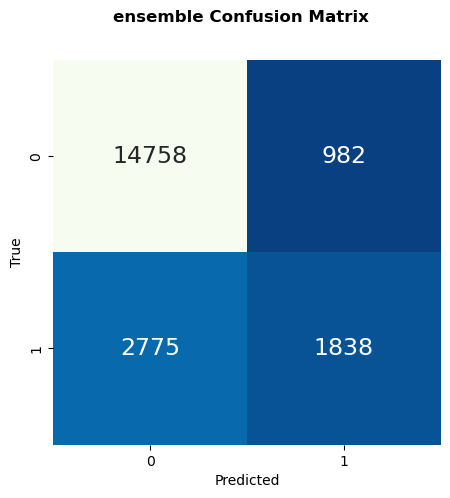

In [85]:
cm=confusion_matrix(y_origin_val, val_preds)
plot_confusion_matrix(cm, 'ensemble Confusion Matrix', 'ensemble')

balance!! [1, 1, 1, 1, 1]
chosen models : ['lightgbm', 'logistic_nystroem'], weights : [1, 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost'], weights : [1, 1, 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7919
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb'], weights : [1, 1, 1, 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7919
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb', 'extra'], weights : [1, 1, 1, 1, 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss :

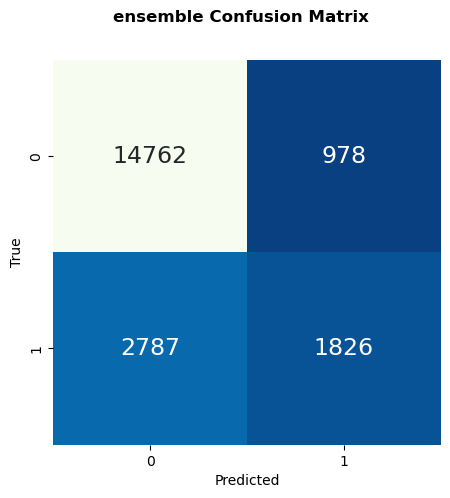

In [86]:
# balance
best_model, k, best_score, weights = run_k_fold(X_origin_train, y_origin_train, models, model_scores, num=5, weight='balance')
# 위에서 최고의 앙상블 모델 validation auc score 측정
chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(k)]
chosen_model_names = [model_scores[m_idx][0] for m_idx in range(k)]
val_preds_proba = best_model.predict_proba(X_origin_val)[:, 1]
val_preds = best_model.predict(X_origin_val)
val_score = roc_auc_score(y_origin_val, val_preds_proba)

print(f'{k}개 앙상블, chosen models : {chosen_model_names}')
print("Validation auc roc : %.4f" % val_score)
print("Validation acc : %.4f" % accuracy_score(y_origin_val, val_preds))
print("Validation f1_score : %.4f" % f1_score(y_origin_val, val_preds))
cm=confusion_matrix(y_origin_val, val_preds)
plot_confusion_matrix(cm, 'ensemble Confusion Matrix', 'ensemble')

square!! [25 16  9  4  1]
chosen models : ['lightgbm', 'logistic_nystroem'], weights : [4 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7918
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost'], weights : [9 4 1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7919
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb'], weights : [16  9  4  1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb', 'extra'], weights : [25 16  9  4  1]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 

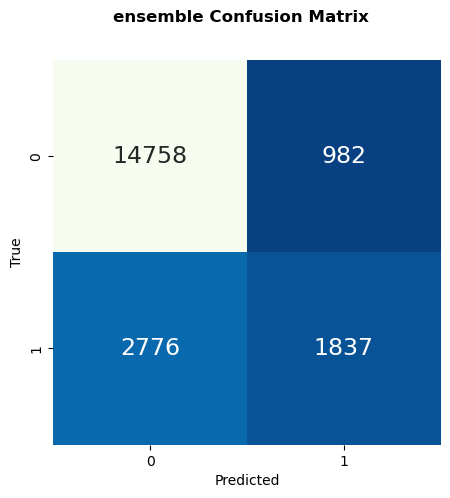

In [87]:
# None
best_model, k, best_score, weights = run_k_fold(X_origin_train, y_origin_train, models, model_scores, num=5, weight='square')
# 위에서 최고의 앙상블 모델 validation auc score 측정
chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(k)]
chosen_model_names = [model_scores[m_idx][0] for m_idx in range(k)]
val_preds_proba = best_model.predict_proba(X_origin_val)[:, 1]
val_preds = best_model.predict(X_origin_val)
val_score = roc_auc_score(y_origin_val, val_preds_proba)

print(f'{k}개 앙상블, chosen models : {chosen_model_names}')
print("Validation auc roc : %.4f" % val_score)
print("Validation acc : %.4f" % accuracy_score(y_origin_val, val_preds))
print("Validation f1_score : %.4f" % f1_score(y_origin_val, val_preds))
cm=confusion_matrix(y_origin_val, val_preds)
plot_confusion_matrix(cm, 'ensemble Confusion Matrix', 'ensemble')

sqrt!! [2.23606798 2.         1.73205081 1.41421356 1.        ]
chosen models : ['lightgbm', 'logistic_nystroem'], weights : [1.41421356 1.        ]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost'], weights : [1.73205081 1.41421356 1.        ]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7919
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb'], weights : [2.         1.73205081 1.41421356 1.        ]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb', 'extra'], weights : [2.23606798 2.         1.73205081 1.41421356 1.       

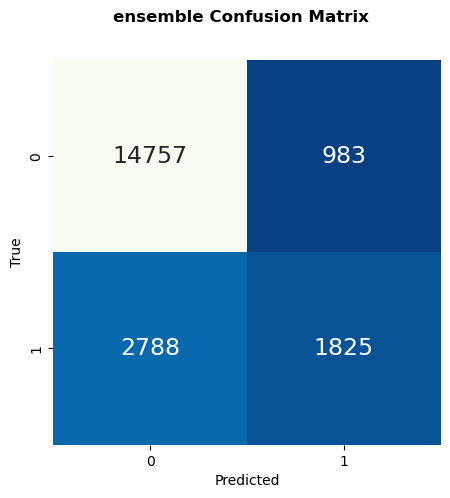

In [88]:
# None
best_model, k, best_score, weights = run_k_fold(X_origin_train, y_origin_train, models, model_scores, num=5, weight='sqrt')
# 위에서 최고의 앙상블 모델 validation auc score 측정
chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(k)]
chosen_model_names = [model_scores[m_idx][0] for m_idx in range(k)]
val_preds_proba = best_model.predict_proba(X_origin_val)[:, 1]
val_preds = best_model.predict(X_origin_val)
val_score = roc_auc_score(y_origin_val, val_preds_proba)

print(f'{k}개 앙상블, chosen models : {chosen_model_names}')
print("Validation auc roc : %.4f" % val_score)
print("Validation acc : %.4f" % accuracy_score(y_origin_val, val_preds))
print("Validation f1_score : %.4f" % f1_score(y_origin_val, val_preds))
cm=confusion_matrix(y_origin_val, val_preds)
plot_confusion_matrix(cm, 'ensemble Confusion Matrix', 'ensemble')

log!! [1.79175947 1.60943791 1.38629436 1.09861229 0.69314718]
chosen models : ['lightgbm', 'logistic_nystroem'], weights : [1.09861229 0.69314718]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost'], weights : [1.38629436 1.09861229 0.69314718]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb'], weights : [1.60943791 1.38629436 1.09861229 0.69314718]
========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7920
chosen models : ['lightgbm', 'logistic_nystroem', 'xgboost', 'hgb', 'extra'], weights : [1.79175947 1.60943791 1.38629436 1.09861229 0.69314718

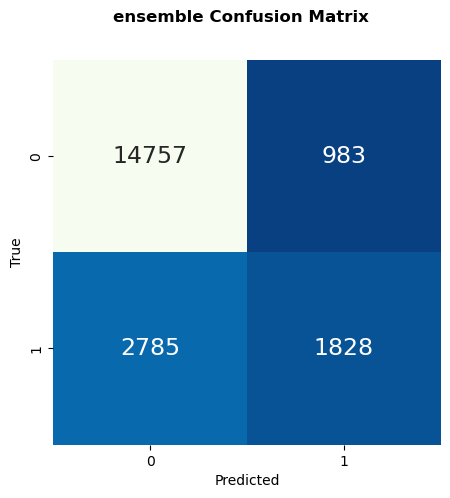

In [89]:
# None
best_model, k, best_score, weights = run_k_fold(X_origin_train, y_origin_train, models, model_scores, num=5, weight='log')
# 위에서 최고의 앙상블 모델 validation auc score 측정
chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(k)]
chosen_model_names = [model_scores[m_idx][0] for m_idx in range(k)]
val_preds_proba = best_model.predict_proba(X_origin_val)[:, 1]
val_preds = best_model.predict(X_origin_val)
val_score = roc_auc_score(y_origin_val, val_preds_proba)

print(f'{k}개 앙상블, chosen models : {chosen_model_names}')
print("Validation auc roc : %.4f" % val_score)
print("Validation acc : %.4f" % accuracy_score(y_origin_val, val_preds))
print("Validation f1_score : %.4f" % f1_score(y_origin_val, val_preds))
cm=confusion_matrix(y_origin_val, val_preds)
plot_confusion_matrix(cm, 'ensemble Confusion Matrix', 'ensemble')

In [93]:
# 같은 옵션으로 앙상블 모델 구성
# 전체 데이터로 학습
model_num = 4
weights = [5,4,3,2,1]
chosen_models = [(model_scores[m_idx][0], models[model_scores[m_idx][0]]) for m_idx in range(model_num)]
chosen_models

[('lightgbm',
  LGBMClassifier(colsample_bytree=0.5428020772717417,
                 learning_rate=0.014397706060401805, max_depth=20,
                 min_child_samples=36, n_estimators=434, num_leaves=32,
                 random_state=61)),
 ('logistic_nystroem',
  Pipeline(steps=[('columntransformer',
                   ColumnTransformer(remainder='passthrough',
                                     transformers=[('onehot',
                                                    OneHotEncoder(handle_unknown='ignore'),
                                                    ['lOBlank_c', 'branchCount_c',
                                                     'mean_sum', 'pure_sum'])])),
                  ('functiontransformer',
                   FunctionTransformer(func=<ufunc 'log1p'>)),
                  ('nystroem', Nystroem(n_components=400, random_state=61)),
                  ('standardscaler', StandardScaler()),
                  ('logisticregression',
                   LogisticRegress

In [94]:
final_model = VotingClassifier(chosen_models, weights = weights[5-model_num:], voting = 'soft')
oof, oof_score = oof_preds(X, y, final_model)
print(f'전체 데이터 validation auc score : {oof_score}')

========== Fold 1 ==========
========== Fold 2 ==========
========== Fold 3 ==========
========== Fold 4 ==========
========== Fold 5 ==========
Loss : 0.7924
전체 데이터 validation auc score : 0.7923548375081776


In [95]:
submission['defects'] = final_model.predict_proba(test_df)[:, 1]

In [96]:
submission.to_csv(data_path+'submission/ensemble_final.csv')

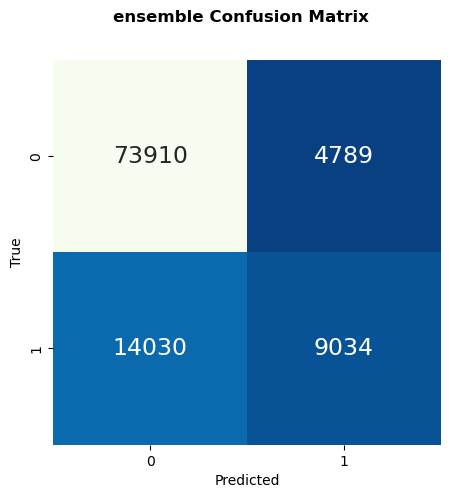

In [97]:
cm=confusion_matrix(y, oof>=0.5)
plot_confusion_matrix(cm, 'ensemble Confusion Matrix', 'ensemble')